# Quick Overview

This tutorial will help you get started with basic usage of the FanInSAR library. We will cover the following topics:

- How to initialize a dataset
- How to query values from dataset by given points/bounding boxes/polygons
- How to operate time series processing (e.g., unwrapping error correction, NSBAS inversion, etc.)
- How to save the processed results into tiff/kml(kmz) files

## Imports

Customarily, we import FanInSAR as follows:

In [29]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import faninsar as fis
from faninsar import datasets, NSBAS, query, constants, cmaps

## Load InSAR datasets

FanInSAR provides a series of [datasets](#geo_datasets) to load well-known InSAR products. Here we will use the [HyP3S1](#faninsar.datasets.HyP3S1) for example, which is used to load the HyP3 Sentinel-1 frame dataset. 

### Initialize a dataset

To initialize the [HyP3S1](#faninsar.datasets.HyP3S1) class, you only need to provide the root directory of the HyP3 data. All unwrapped interferogram and coherence files stored in the root directory, including the subdirectories, will be automatically scanned. 

In [2]:
root_dir = Path("/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/descending_roi/")
ds_unw = datasets.HyP3S1(root_dir)

:::{tip}
- You can also directly provide the ``paths_unw`` and ``paths_coh`` arguments to specify the paths of the unwrapped and coherence files. In this case, the ``root_dir`` argument will be ignored. 
- Only common pairs of the unwrapped interferogram and coherence files will be used. The rest of the files will be ignored automatically.
:::


:::{admonition} More initialization parameters
:class: dropdown

Below are the common parameters to initialize a dataset:

- **crs, res, resampling**:  
  - If the dataset files are not aligned with the specified `crs` (Coordinate Reference System) or `res` (resolution), the warp process, such as resampling and reprojection, will be performed to align the dataset files with the specified `crs` and `res` automatically. ([Here](#warp_example) are some examples of usage)
  - The `resampling` parameter is employed to define the resampling algorithm used in the warp process. The default value is `Resampling.nearest`. More resampling algorithms can be found [here](#rasterio.enums.Resampling).
- **fill_nodata**: If `True`, the nodata values in raster files will be interpolated using inverse distance weighting method provided by the [rasterio.fill.fillnodata()](#rasterio.fill.fillnodata).
- **roi**: region of interest, which defines the specific area to be loaded from the dataset. If left as `None`, the combined boundary of all files within the dataset will be utilized.
- **verbose**: Enabling `verbose=True` will display the dataset processing information. To suppress this output, set the parameter to `False`.
:::

### Interferogram dataset

[HyP3S1](#faninsar.datasets.HyP3S1) is a subclass of [RasterDataset](#faninsar.datasets.RasterDataset) and provides the same functionalities/properties as [RasterDataset](#faninsar.datasets.RasterDataset). You can view interferogram file by directly calling `files` property. The file paths and whether the file is valid or not will be displayed in the DataFrame format.

In [3]:
ds_unw.files

,paths,valid
0,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
1,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
3,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
4,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
...,...,...
2745,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2746,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2747,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2748,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True


We keep the same API with `rasterio` for the dataset, so you can use directly access the resolution, bounds, and other properties of the dataset just like using rasterio. 

:::{important}
The `res`, `crs`, `dtypes` and `nodata` are the output properties of the dataset, which can be specified by the user when initializing the dataset. The actual properties of the raster files may be different from the those properties.
:::

In [4]:
print(f" res: {ds_unw.res}\n bounds: {ds_unw.bounds}\n crs: {ds_unw.crs}\n dtype: {ds_unw.dtype}\n nodata: {ds_unw.nodata}")

 res: (40.0, 40.0)
 bounds: BoundingBox(left=443501.82025355106, bottom=4263758.21737383, right=536101.820253551, top=4335118.21737383, crs=EPSG:32647)
 crs: EPSG:32647
 dtype: float32
 nodata: 0.0


### Coherence dataset

The coherence dataset can be accessed by the `coh_dataset` property of the [HyP3S1](#faninsar.datasets.HyP3S1) object. The coherence dataset is also a [RasterDataset](#faninsar.datasets.RasterDataset) object, so you can access the properties of the coherence dataset just like the unwrapped interferograms.

In [5]:
ds_coh = ds_unw.coh_dataset
ds_coh.files

,paths,valid
0,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
1,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
3,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
4,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
...,...,...
2745,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2746,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2747,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2748,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True


## Query values by Points/Boxes/Polygons

FanInSAR provides a [query](#query_module) module, which defines a series of classes to query/sample values from the dataset by given points, bounding boxes, or polygons and store the results of the queries.

### Define queries

:::{admonition} Query types in FanInSAR
:class: dropdown

There are four types of queries in the query module: [Points](#faninsar.query.Points), [BoundingBox](#faninsar.query.BoundingBox),  [Polygons](#faninsar.query.Polygons), and [GeoQuery](#faninsar.query.GeoQuery):

- **Points**: A collection of points, can be used to sample multiple pixel values from GeoDataset.
- **BoundingBox**: A bounding box, can be used to sample rectangular region values from GeoDataset.
- **Polygons**: A collection of polygons, can be used to sample multiple polygon values from GeoDataset.
- **GeoQuery**: A combination of `Points`, `BoundingBox`, and `Polygons`. It is highly recommended if you want to sample values using multiple query types simultaneously.
:::


Below is an example of how to define a `GeoQuery` containing both reference points and a bounding box

In [6]:
# initialize a Points instance from a shape file
ref_file = "/Volumes/Data/GeoData/YNG/ARPs.geojson"
ref_points = query.Points.from_shapefile(ref_file)

# define a bounding box
roi = query.BoundingBox(
    98.86517887, 38.78630936, 98.90998476, 38.83929150, crs="EPSG:4326"
)

# define a GeoQuery, which is a combination of a bounding box and a set of reference points
geo_query = query.GeoQuery(boxes=roi, points=ref_points)

### Query values by `GeoQuery`

There are two methods to query values from a dataset: using `[]` and using the `query()` method. 

#### Query by `[]`

This is a direct querying method, suitable when you only need to retrieve all valid pairs.

In [7]:
unw_sample1 = ds_unw[geo_query]

Loading Interferogram Files: 100%|██████████| 2750/2750 [00:57<00:00, 47.52 files/s]


#### Query by `query()` method

This method offers more flexibility, allowing you to query the values of a subset of pairs by specifying the `pairs` parameter.

In [38]:
# select pairs that temporal baseline is less than 60 days
pairs = ds_unw.pairs
pairs_idx = (pairs.days <= 60) & (
    pairs.where(pairs["2017-01":], return_type="mask")
)
pairs_used = pairs[pairs_idx]
# query the dataset with the selected pairs
unw_sample2 = ds_unw.query(geo_query, pairs=pairs_used)

Loading Interferogram Files: 100%|██████████| 881/881 [00:20<00:00, 43.56 files/s]


### Query results 

:::{admonition} Query results properties
:class: dropdown
[QueryResult](query_result) class is used to store the query results. It contains the following four properties:

- **points**: Result of the `Points` query.
- **boxes**: Result of the `BoundingBox` query.
- **polygons**: Result of the `Polygons` query.
- **query**: The original `GeoQuery` instance used to query the dataset.
:::

check the query results for `[]` method

In [39]:
unw_sample1

QueryResult(
    points=PointsResult(files:2750, points:107),
    boxes=BBoxesResult(files:2750, height:147, width:97),
    polygons=None,
    query=GeoQuery(points=Points(count=107, crs='EPSG:4326'), boxes=[1 BoundingBox], polygons=None)
)

check the query results for `query()` method

In [40]:
unw_sample2

QueryResult(
    points=PointsResult(files:881, points:107),
    boxes=BBoxesResult(files:881, height:147, width:97),
    polygons=None,
    query=GeoQuery(points=Points(count=107, crs='EPSG:4326'), boxes=[1 BoundingBox], polygons=None)
)

:::{tip}
For each query type, masked numpy array values are stored in the `data` property, and the corresponding dimensions are stored in the `dims` property.
:::

We typically take the mean phase values of multiple reference points as the final reference point value. In *FanInSAR*, re-referencing process can be easily achieved by the code below:

In [41]:
# calculate the mean phase values of multiple reference points
ref_values = unw_sample2.points.data.mean(axis=1)

# re-referencing the phases
unw_img = unw_sample2.boxes.data - ref_values[:, None, None]

## Time-series processing

### Unwrapping error correction

Here, we will demonstrate how to correct the unwrapping errors in the interferograms using the method presented in the poster: ["Does InSAR Time Series Using C-band Sentinel-1 Data Underestimate Surface Deformation Over Permafrost Regions on Qinghai-Tibetan Plateau?"](https://agu23.ipostersessions.com/default.aspx?s=7E-2A-74-4D-47-0B-85-B9-6A-ED-25-42-9B-4A-48-87)

In this tutorial, the interferograms with temporal baselines less than 12 days are treated as the reliable `edge pairs`, and are used to correct the unwrapping errors in the `diagonal pairs`, which temporal baselines are longer than 12 days.

In [51]:
# filter the edges pairs with temporal baseline less than 12 days
edge_pairs = pairs_used[pairs_used.days <= 12]

# get the loops with edges pairs
loops = pairs_used.to_loops(max_acquisition=6, edge_pairs=edge_pairs)
loops

Loops(
    loops=668,
    pairs=845,
    edge_pairs=177,
    diagonal_pairs=668
)

In [52]:
# reshape the unw_img to 2D array (n_img, n_pixel) for the following calculation
n_img, n_row, n_col = unw_img.shape
unw = unw_img.reshape(n_img, -1)

# =============================================================================
# there are cases that not all the pairs are used in the loops
# so we need to select the pairs that are used in the loops
# =============================================================================

idx = pairs_used.where(loops.pairs)
unw_used = unw[idx]

# calculate the correction term u
u = np.zeros_like(unw, dtype=np.float32)
u[idx] = np.round(NSBAS.calculate_u(loops, unw_used))

# calculate the corrected interferometric phases
unw_c = unw - 2 * np.pi * u

### NSBAS inversion chain

#### Convert phase to deformation 

In [53]:
pdc = fis.PhaseDeformationConverter(constants.freq.SENTINEL1)
d = pdc.phase2deformation(unw)
d_c = pdc.phase2deformation(unw_c)

#### Define time series model

In [54]:
ts_model = NSBAS.AnnualSemiannualSinusoidal(pairs_used.dates)

#### Operate NSBAS inversion

In [55]:
matrix_factory = NSBAS.NSBASMatrixFactory(d, pairs_used, ts_model)
sbas_inverse = NSBAS.NSBASInversion(matrix_factory, device="cpu")
inc, params, residual_pair, residual_tsm = sbas_inverse.inverse()
cum = np.cumsum(inc, axis=0)

  NSBAS inversion: 100%|██████████| 7130/7130 [00:10<00:00, 693.01Batch/s]


In [56]:
matrix_factory = NSBAS.NSBASMatrixFactory(d_c, pairs_used, ts_model)
sbas_inverse = NSBAS.NSBASInversion(matrix_factory, device="cpu")
inc_c, params_c, residual_pair_c, residual_tsm_c = sbas_inverse.inverse()
cum_c = np.cumsum(inc_c, axis=0)

  NSBAS inversion: 100%|██████████| 4753/4753 [00:10<00:00, 455.07Batch/s]


### Compare corrected and uncorrected results

In [57]:
amplitude = 2 * np.sqrt(params[0] ** 2 + params[1] ** 2).reshape(n_row, n_col)
amplitude_c = 2 * np.sqrt(params_c[0] ** 2 + params_c[1] ** 2).reshape(n_row, n_col)

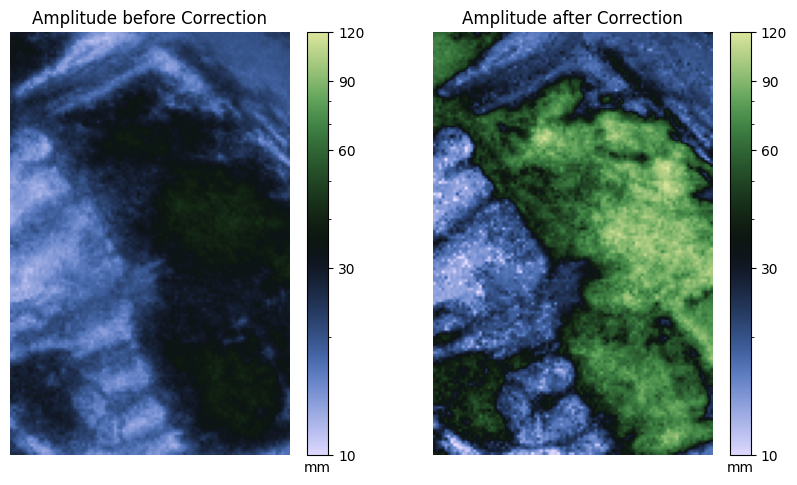

In [63]:
from matplotlib.colors import LogNorm

ticks = [10, 30, 60, 90, 120]
norm = LogNorm(vmin=10, vmax=120)

def plot_amplitude(amplitude, ax, title):
    im = ax.imshow(amplitude, cmap=cmaps.tofino, norm=norm)
    ax.axis("off")
    ax.set_title(title)
    cb = fig.colorbar(im, ax=ax)

    cb.ax.set_yscale('log')
    cb.ax.set_xlabel('mm')
    cb.ax.set_yticks(ticks, labels=ticks)

fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))
plot_amplitude(amplitude, axs[0], "Amplitude before Correction")
plot_amplitude(amplitude_c, axs[1], "Amplitude after Correction")

## Save results